# multiscale model fitting for Toy2a

Toy2a is a simplified version of toy2

### start with initalizing many things

In [1]:
# imports
import os
import sys
import torch
# import pickle
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm
# import time
import math

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
# import torch_cae_multilevel_V4 as net
import ResNet as tnet
import utils

reloaded
using new ResNet thing


In [2]:
# paths
data_dir = '../data/toy2a'
model_dir = '../model/toy2a'
result_dir = '../result/toy2a'

#load data
train_data = torch.tensor(np.load(os.path.join(data_dir, 'train_data.npy')))
val_data = torch.tensor(np.load(os.path.join(data_dir, 'val_data.npy')))
test_data = torch.tensor(np.load(os.path.join(data_dir, 'test_data.npy')))

data_of_sizes = {}
current_size = 1
unresolved_dict = {}
model_keep = list()
model_used_dict = {}


In [3]:

train_dict = utils.make_dict_all_sizes(train_data)
val_dict = utils.make_dict_all_sizes(val_data)

i =  0
Transforming
reshape to print
i =  1
Transforming
reshape to print
i =  2
Transforming
reshape to print
dict_keys(['8', '4', '2', '1'])
i =  0
Transforming
reshape to print
i =  1
Transforming
reshape to print
i =  2
Transforming
reshape to print
dict_keys(['8', '4', '2', '1'])


In [6]:
# import ResNet as tnet
current_size = 1
print(train_dict[str(current_size)].shape)
print(val_dict[str(current_size)].shape)
models, step_sizes, mse_list, idx_lowest,n_forward_list = utils.find_best_timestep(train_dict[str(current_size)], 
                                                              val_dict[str(current_size)], 
                                                              val_dict[str(current_size)], current_size,model_dir=model_dir,# make_new=True, #print_every=100, 
                                                             largest_k = 6, dont_train = False)

torch.Size([100, 500, 1, 1])
torch.Size([10, 500, 1, 1])
inside train_one_timestep
model loaded:  model_L1_D1_noise0.pt
epoch  0 : train_error:  4.089914e-06 : val_loss  0.006280738
epoch  100 : train_error:  3.4682112e-06 : val_loss  3.4147251e-06
epoch  200 : train_error:  2.6727676e-06 : val_loss  2.669073e-06
epoch  300 : train_error:  2.3380953e-06 : val_loss  2.3343614e-06
epoch  400 : train_error:  1.9745823e-06 : val_loss  1.9696354e-06
epoch  500 : train_error:  1.5816534e-06 : val_loss  1.5771743e-06
epoch  600 : train_error:  1.1842386e-06 : val_loss  1.1790537e-06
epoch  700 : train_error:  8.297917e-07 : val_loss  8.257665e-07
epoch  800 : train_error:  5.58801e-07 : val_loss  5.556258e-07
epoch  900 : train_error:  3.761682e-07 : val_loss  3.7409671e-07
inside train_one_timestep
model loaded:  model_L1_D2_noise0.pt
epoch  0 : train_error:  4.9308933e-06 : val_loss  0.0044549014
epoch  100 : train_error:  5.5200835e-06 : val_loss  5.5609135e-06
epoch  200 : train_error:  3

4
step_sizes =  [1, 2, 4, 8, 16, 32]
mse =  [0.15509757548570632, 0.17451325356960296, 0.033365211868658665, 0.05698711275763344, 0.08220795240486041, 0.20367745397379622]
y_preds[i] shape =  (122,)


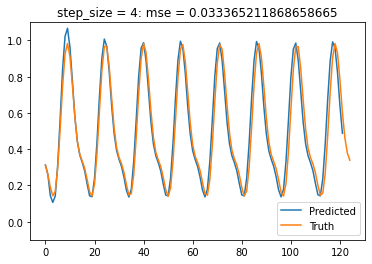

In [7]:
import ResNet as tnet

print(step_sizes[idx_lowest])    
print("step_sizes = ", step_sizes)
print("mse = ", mse_list)
utils.plot_lowest_error(models[idx_lowest], i =0, title="step_size = " +str(step_sizes[idx_lowest]))

# print(train_data.shape)
# dataset = tnet.DataSet(torch.flatten(train_data, 2,3), torch.flatten(val_data, 2,3), 
#                        torch.flatten(val_data, 2,3), 1, step_sizes[idx_lowest], 5)
# dataset.plot_val_data()

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1 2
y_pred shape =  (10, 122)
truth_with_step_size[:,3:] shape =  torch.Size([10, 122, 2, 2])


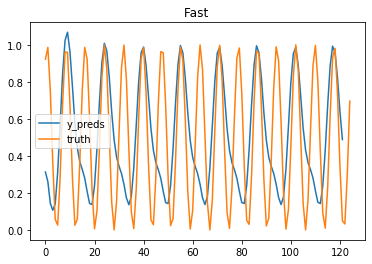

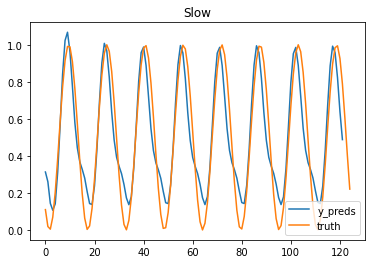

(2, 2)
[[0.18238684 0.04680965]
 [0.04680965 0.04680965]]


In [8]:
import utils

resolved, loss, unresolved_list = utils.find_error_4(val_dict['1'], models[idx_lowest], val_dict['2'], plot = True)
print(loss.shape)
print(loss)



In [9]:

unresolved_dict[str(current_size)] = torch.tensor(unresolved_list)

print(unresolved_list)

tensor([[1., 1.],
        [1., 1.]])


/tmp/ipykernel_232/3110518613.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unresolved_dict[str(current_size)] = torch.tensor(unresolved_list)


torch.Size([100, 500, 2, 2])


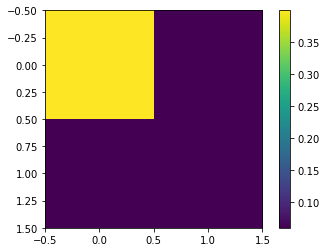

In [10]:
current_size = 1
next_train_data = unresolved_list * train_dict[str(current_size*2)]
print(next_train_data.shape)
plt.imshow(next_train_data[0,0])
plt.colorbar()
plt.show()

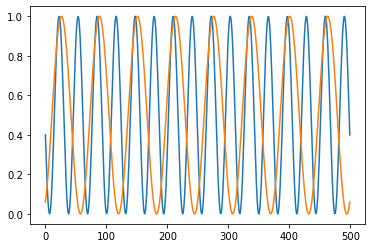

In [11]:
plt.plot(train_dict[str(current_size*2)][0,:,0,0])
plt.plot(train_dict[str(current_size*2)][0,:,0,1])

In [12]:
model_keep = [models[idx_lowest]]
model_used_dict[str(current_size)] = [[0]]

In [13]:
import utils




current_size = 2
next_train_data = unresolved_list * train_dict[str(current_size)]

model_idx_list = np.ones((current_size, current_size))*(-1) #start with all -1

for i in range(current_size):
    for j in range(current_size):
        print("i = ", i, ": j = ", j)
        data_this = next_train_data[:,:,i,j]
        if (torch.min(data_this) == 0) and (torch.max(data_this) == 0):
            print("zero, no need to train")
            #don't need to do anything is model is resolved
            continue
        else:
        #see if the error is low enough on already made model
            for m, model in enumerate(model_keep):
                loss, resolved = utils.find_error_1(data_this, model)
                step_size = model.step_size
                print("model ", m, " has loss = ", loss)
                if resolved:
                    model_idx_list[i,j] = m
                    print("Resolved with loss = ", loss, ": model #", m)
                    break
                else:
                    pass
            if not resolved:
                print("not resolved, fitting new model")
                k = int(np.log2(step_size))
                #if no model good, train new model
                models, step_sizes, mse_list, idx_lowest, n_forward_list = utils.find_best_timestep(train_dict[str(current_size)][:,:,i,j], 
                                                              val_dict[str(current_size)][:,:,i,j], 
                                                              val_dict[str(current_size)][:,:,i,j], current_size,model_dir=model_dir,#make_new = True,
                                                              i=i, j=j, start_k = max(0,k-1), largest_k = k+2)
                
                model_keep.append(models[idx_lowest])
                model_idx_list[i,j] = len(model_keep)-1
model_used_dict[str(current_size)] = model_idx_list

i =  0 : j =  0
model  0  has loss =  0.16862049251794814
not resolved, fitting new model
inside train_one_timestep
create model ../model/toy2a/model_L2_D2_noise0_i0_j0.pt ...
data shape =  torch.Size([100, 500, 1, 1])
data shape =  torch.Size([10, 500, 1, 1])
epoch  0 : train_error:  0.3412269 : val_loss  0.33567166
epoch  100 : train_error:  0.06468257 : val_loss  0.063128956
epoch  200 : train_error:  0.00040889505 : val_loss  0.00040364798
epoch  300 : train_error:  0.00011352617 : val_loss  0.00011314668
epoch  400 : train_error:  6.42861e-05 : val_loss  6.412541e-05
epoch  500 : train_error:  3.794095e-05 : val_loss  3.7720696e-05
epoch  600 : train_error:  1.950435e-05 : val_loss  1.9367975e-05
epoch  700 : train_error:  8.039027e-06 : val_loss  7.952156e-06
epoch  800 : train_error:  3.646468e-06 : val_loss  3.6136232e-06
epoch  900 : train_error:  2.542568e-06 : val_loss  2.5303186e-06
inside train_one_timestep
create model ../model/toy2a/model_L2_D4_noise0_i0_j0.pt ...
data s

epoch  100 : train_error:  0.0365655 : val_loss  0.03569219
epoch  200 : train_error:  0.005295584 : val_loss  0.0050335387
epoch  300 : train_error:  0.00013755039 : val_loss  0.00013497639
epoch  400 : train_error:  2.6911497e-05 : val_loss  2.660745e-05
epoch  500 : train_error:  1.1492126e-05 : val_loss  1.1278618e-05
epoch  600 : train_error:  6.0121433e-06 : val_loss  5.9177773e-06
epoch  700 : train_error:  3.3002823e-06 : val_loss  3.243301e-06
epoch  800 : train_error:  2.2930158e-06 : val_loss  2.2622678e-06
epoch  900 : train_error:  1.8578785e-06 : val_loss  1.841032e-06
inside train_one_timestep
create model ../model/toy2a/model_L2_D4_noise0_i1_j1.pt ...
data shape =  torch.Size([100, 500, 1, 1])
data shape =  torch.Size([10, 500, 1, 1])
epoch  0 : train_error:  0.32385805 : val_loss  0.3168736
epoch  100 : train_error:  0.0898708 : val_loss  0.08849007
epoch  200 : train_error:  0.0008391105 : val_loss  0.00077296095
epoch  300 : train_error:  4.106909e-06 : val_loss  4.0

In [47]:
print(model_idx_list)
print(len(model_keep))
print(model_used_dict)

[[1. 2.]
 [2. 2.]]
3
{'1': [[0]], '2': array([[1., 2.],
       [2., 2.]])}


1.0
model_L2_D2_noise0_i0_j0.pt
1 2
y_pred shape =  (10, 247)
truth_with_step_size[:,3:] shape =  torch.Size([10, 247, 2, 2])


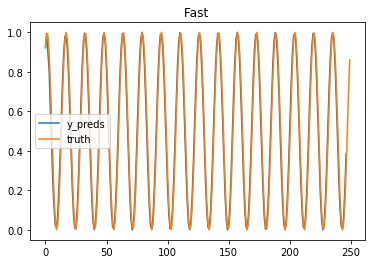

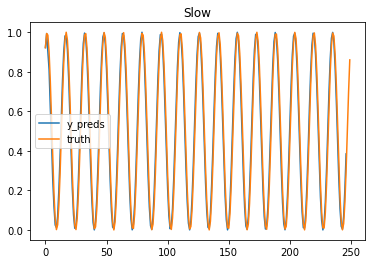

[[0.01559533 0.01559533]
 [0.01559533 0.01559533]]
tensor([[0., 0.],
        [0., 0.]])
2.0
model_L2_D4_noise0_i0_j1.pt
1 2
y_pred shape =  (10, 122)
truth_with_step_size[:,3:] shape =  torch.Size([10, 122, 2, 2])


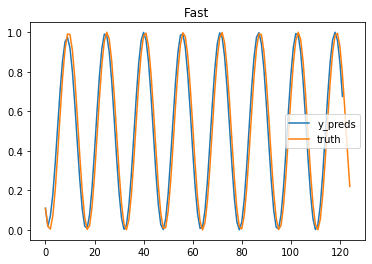

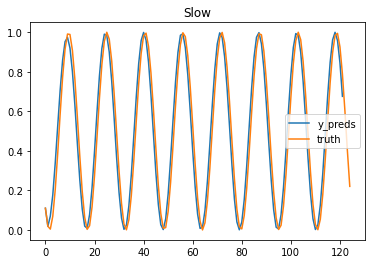

[[0.01345305 0.01345305]
 [0.01345305 0.01345305]]
tensor([[0., 0.],
        [0., 0.]])
2.0
model_L2_D4_noise0_i0_j1.pt
1 2
y_pred shape =  (10, 122)
truth_with_step_size[:,3:] shape =  torch.Size([10, 122, 2, 2])


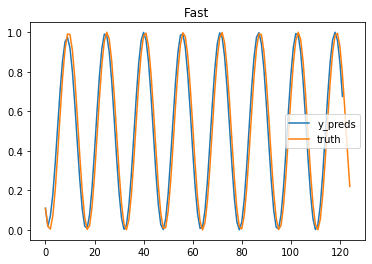

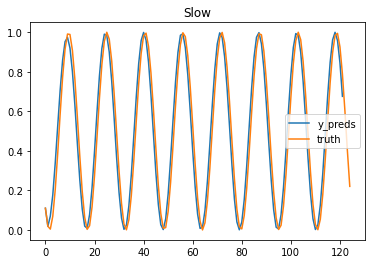

[[0.01345305 0.01345305]
 [0.01345305 0.01345305]]
tensor([[0., 0.],
        [0., 0.]])
2.0
model_L2_D4_noise0_i0_j1.pt
1 2
y_pred shape =  (10, 122)
truth_with_step_size[:,3:] shape =  torch.Size([10, 122, 2, 2])


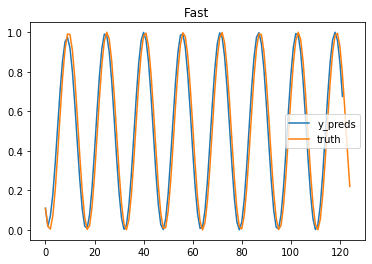

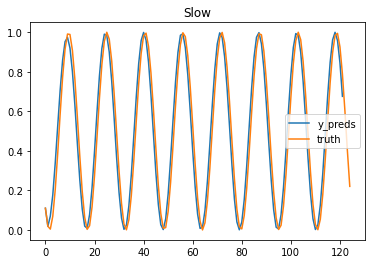

[[0.01345305 0.01345305]
 [0.01345305 0.01345305]]
tensor([[0., 0.],
        [0., 0.]])
all_resolved =  True
unresolved_list_big =  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [49]:
import utils
#once we have all 4 figured out, need to check the errors on the 2x2 of the 2x2s (the 4x4)
unresolved_list_big = np.ones((4,4))*(-1)
all_resolved = True
for i in range(2):
    for j in range(2):
        print(model_used_dict['2'][i][j])
        model = model_keep[int(model_used_dict['2'][i][j])]
        print(model.model_name)
        data_next = val_dict['4'][:,:, i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size]
        resolved, loss, unresolved_list = utils.find_error_4(val_dict['2'][i,j], model, data_next,plot = True)
        unresolved_list_big[i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size] = unresolved_list
        if not resolved:
            all_resolved = False
        print(loss)
        print(unresolved_list)
print("all_resolved = ", all_resolved)
print("unresolved_list_big = ", unresolved_list_big)

In [34]:
print(step_sizes, mse_list, idx_lowest)
resolved, loss, unresolved_list = utils.find_error_4(val_dict[str(current_size)][:,:,i,j], 
                                                               models[idx_lowest], 
                                                               val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size])
print(loss)    

[1, 2, 4, 8, 16, 32] [0.16154877096414566, 0.15157305151224137, 0.02454428288328927, 0.05149748913245276, 0.08118089624913409, 0.23986651519080623] 2


IndexError: index 1 is out of bounds for dimension 2 with size 1

In [33]:
model =  models[idx_lowest]
print(idx_lowest)
n_timesteps = 500
n_points = 10
dim = 1
# plt.plot(model(val_dict[str(current_size)][:,:,i,j].unsqueeze(2).unsqueeze(3))[0,:,0,0].detach().numpy(), label = "predicted")
print(val_dict[str(current_size)][:,0,i,j].unsqueeze(1).shape)
val_data_this = val_dict[str(current_size)][:,0,i,j].unsqueeze(1)
predicted = model.uni_scale_forecast(val_data_this, n_steps=n_timesteps-1)
print(predicted.shape)
predicted_reshape = predicted.reshape((  n_points, n_timesteps-1, dim,dim))
plt.plot(predicted_reshape[0,:,0], label = "predicted")
print(val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size].shape)
# plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,0], label = "Truth")

plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,1], label = "Truth")
plt.legend()

2


IndexError: index 1 is out of bounds for dimension 2 with size 1

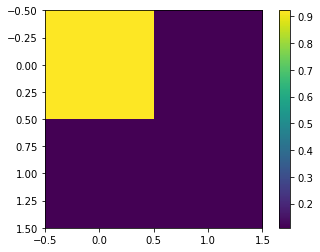

In [32]:
plt.imshow(val_dict[str(current_size*2)][0,0])
plt.colorbar()

In [ ]:
step_size = (16+32)/2
print(step_size)
model = train_one_timestep(int(28), train_dict[str(current_size)][:,:,i,j].unsqueeze(2), 
                           val_dict[str(current_size)][:,:,i,j].unsqueeze(2), 
                           val_dict[str(current_size)][:,:,i,j].unsqueeze(2), current_size)
#                        dt = 1, n_forward = 5, noise=0, make_new = False, dont_train = True, 
#                        lr = 1e-3, max_epochs = 10000, batch_size = 50,threshold = 1e-4, 
#                        model_dir = './models/toy2',i=None, j = None):
    
#     train_dict[str(current_size)][:,:,i,j], 
#                                                               val_dict[str(current_size)][:,:,i,j], 
#                                                               val_dict[str(current_size)][:,:,i,j], current_size,model_dir=model_dir, 
#                                                               i=i, j=j, start_k = max(0,k-1), largest_k = k+2)

In [ ]:
i = 0
j = 1
resolved, loss, unresolved_list = find_error_4(val_dict[str(current_size)][:,:,i,j], 
                                                               model, 
                                                               val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, j*current_size:(j+1)*current_size])
print(loss)

In [ ]:
# model =  models[idx_lowest]
print(idx_lowest)
n_timesteps = 500
n_points = 10
dim = 1
# plt.plot(model(val_dict[str(current_size)][:,:,i,j].unsqueeze(2).unsqueeze(3))[0,:,0,0].detach().numpy(), label = "predicted")
print(val_dict[str(current_size)][:,0,i,j].unsqueeze(1).shape)
val_data_this = val_dict[str(current_size)][:,0,i,j].unsqueeze(1)
predicted = model.uni_scale_forecast(val_data_this, n_steps=n_timesteps-1)
print(predicted.shape)
predicted_reshape = predicted.reshape((  n_points, n_timesteps-1, dim,dim))
plt.plot(predicted_reshape[0,:,0], label = "predicted")
print(val_dict[str(current_size*2)][:,:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size].shape)
# plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,0], label = "Truth")

plt.plot(val_dict[str(current_size*2)][:,1:, i*current_size:(i+1)*current_size, i*current_size:(i+1)*current_size][0,:,0,1], label = "Truth")
plt.legend()